<a href="https://colab.research.google.com/github/XaverB97/AMD_Plants/blob/main/AMD_Plandts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accessing Kaggle API and downloading Dataset

In [ ]:
import os

os.environ["KAGGLE_USERNAME"] = "xaverbrckner"
os.environ["KAGGLE_KEY"] = "1d8640a22386f4cc01b4705ec0ccae23"

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()

In [ ]:
api.authenticate()

In [ ]:
!kaggle datasets download -d 'csafrit2/plant-leaves-for-image-classification'

100% 6.56G/6.56G [03:26<00:00, 37.9MB/s]
100% 6.56G/6.56G [03:26<00:00, 34.1MB/s]


In [ ]:
!unzip -q plant-leaves-for-image-classification.zip

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input,Flatten, Dropout,GlobalMaxPooling2D,Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from IPython.display import Image
from tqdm import tqdm
import cv2

In [ ]:
directory = "/content/Plants_2"
folders = ["images to predict", "test", "train", "valid"]
plants = ['Alstonia Scholaris diseased (P2a)', 
          'Alstonia Scholaris healthy (P2b)', 
          'Arjun diseased (P1a)', 
          'Arjun healthy (P1b)', 
          'Bael diseased (P4b)', 
          'Chinar diseased (P11b)', 
          'Chinar healthy (P11a)', 
          'Gauva diseased (P3b)', 
          'Gauva healthy (P3a)', 
          'Jamun diseased (P5b)', 
          'Jamun healthy (P5a)', 
          'Jatropha diseased (P6b)', 
          'Jatropha healthy (P6a)', 
          'Lemon diseased (P10b)', 
          'Lemon healthy (P10a)', 
          'Mango diseased (P0b)', 
          'Mango healthy (P0a)', 
          'Pomegranate diseased (P9b)', 
          'Pomegranate healthy (P9a)', 
          'Pongamia Pinnata diseased (P7b)', 
          'Pongamia Pinnata healthy (P7a)',
          'Basil healthy (P8)']



plant_label = {'Alstonia Scholaris diseased (P2a)': 1,
                'Alstonia Scholaris healthy (P2b)': 1,
                'Arjun diseased (P1a)': 2,
                'Arjun healthy (P1b)': 2,
                'Bael diseased (P4b)': 3,
                'Chinar diseased (P11b)': 4,
                'Chinar healthy (P11a)': 4,
                'Gauva diseased (P3b)': 5,
                'Gauva healthy (P3a)': 5,
                'Jamun diseased (P5b)': 6,
                'Jamun healthy (P5a)': 6,
                'Jatropha diseased (P6b)': 7,
                'Jatropha healthy (P6a)': 7,
                'Lemon diseased (P10b)': 8,
                'Lemon healthy (P10a)': 8,
                'Mango diseased (P0b)': 9,
                'Mango healthy (P0a)': 9,
                'Pomegranate diseased (P9b)': 10,
                'Pomegranate healthy (P9a)': 10,
                'Pongamia Pinnata diseased (P7b)': 11,
                'Pongamia Pinnata healthy (P7a)': 11,
                'Basil healthy (P8)': 12}

IMAGE_SIZE = (70, 70)


Data Loader

In [ ]:
train_dir = "/content/Plants_2/train/"
test_dir = "/content/Plants_2/test/"
val_dir = "/content/Plants_2/valid/"

In [ ]:
def load_data():
    
    datasets = [train_dir, test_dir, val_dir]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = plant_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.resize(image, IMAGE_SIZE) 
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels), (val_images, val_labels) = load_data()

Loading /content/Plants_2/train/


100%|██████████| 123/123 [00:39<00:00,  3.12it/s]


Loading /content/Plants_2/test/


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


Loading /content/Plants_2/valid/


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


In [ ]:
print((train_images.shape))
print((train_labels.shape))
print((test_images.shape))
print((test_labels.shape))
print((val_images.shape))
print((val_labels.shape))

(4274, 70, 70, 3)
(4274,)
(110, 70, 70, 3)
(110,)
(110, 70, 70, 3)
(110,)


In [ ]:
from sklearn.utils import shuffle 
train_images, train_labels = shuffle(train_images, train_labels, random_state=69)
test_images, test_labels = shuffle(test_images, test_labels, random_state=69)
val_images, val_labels = shuffle(val_images, val_labels, random_state=69)

In [ ]:
#scaling the images
train_images = train_images / 255.0 
test_images = test_images / 255.0
val_images = val_images / 255.0 

In [ ]:
#visualizing some images
def display_examples(class_names, images, labels):
    """
        Display 16 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [ ]:
train_labels[0:100]

array([ 9,  7,  4,  4,  6, 11, 10, 11, 11,  2,  1,  2,  7,  4,  6, 12,  2,
       10,  6,  2, 11,  3, 10, 11, 10,  2,  1,  2, 10,  2,  1,  3,  9,  2,
        5,  5,  5,  5,  2,  3,  2,  7,  4,  6, 10, 11,  4,  6, 10, 10,  6,
       10, 10,  5, 12, 10,  3,  9, 10, 10,  6, 11,  5,  1,  9,  7, 10, 12,
        6,  2, 12,  8,  7,  5,  5,  3,  9,  2,  6,  2,  3,  6, 10,  4,  1,
       10,  5, 12,  2,  9,  8, 11,  2,  9,  1,  3, 12,  2,  7, 11],
      dtype=int32)

(array([412., 432., 107., 203., 398., 603., 237., 216., 414., 538., 577.,
        137.]),
 array([ 1.        ,  1.91666667,  2.83333333,  3.75      ,  4.66666667,
         5.58333333,  6.5       ,  7.41666667,  8.33333333,  9.25      ,
        10.16666667, 11.08333333, 12.        ]),
 <BarContainer object of 12 artists>)

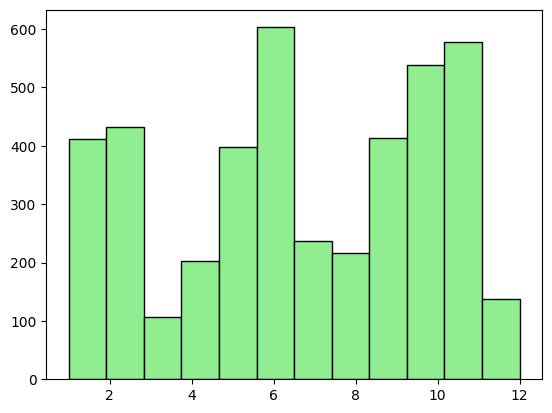

In [ ]:
plt.hist(train_labels, color='lightgreen', ec='black', bins=12)

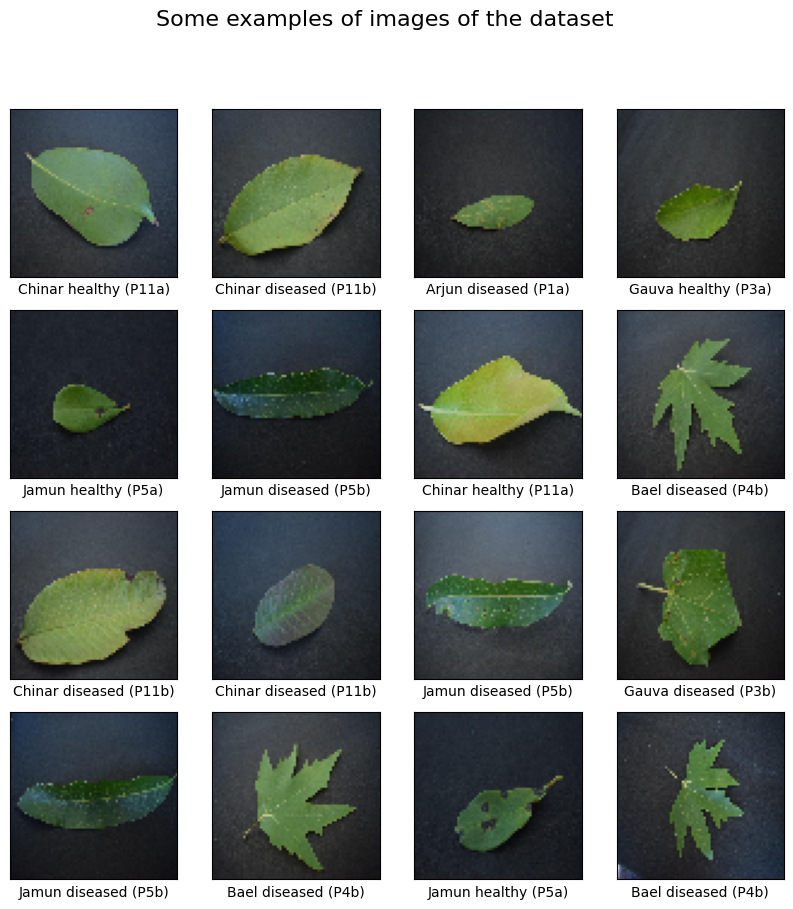

In [ ]:
display_examples(plants, test_images, test_labels)

MODEL 0 - Baseline

Epoch 1/20
67/67 [==============================] - 3s 22ms/step - loss: 2.3268 - accuracy: 0.1652 - val_loss: 2.0930 - val_accuracy: 0.1273
Epoch 2/20
67/67 [==============================] - 1s 14ms/step - loss: 1.7380 - accuracy: 0.4034 - val_loss: 1.6935 - val_accuracy: 0.3636
Epoch 3/20
67/67 [==============================] - 1s 11ms/step - loss: 1.4142 - accuracy: 0.5166 - val_loss: 1.4978 - val_accuracy: 0.4818
Epoch 4/20
67/67 [==============================] - 1s 9ms/step - loss: 1.2342 - accuracy: 0.5880 - val_loss: 1.2669 - val_accuracy: 0.5455
Epoch 5/20
67/67 [==============================] - 1s 9ms/step - loss: 1.0907 - accuracy: 0.6385 - val_loss: 1.2977 - val_accuracy: 0.5364
Epoch 6/20
67/67 [==============================] - 1s 9ms/step - loss: 1.0100 - accuracy: 0.6757 - val_loss: 1.2229 - val_accuracy: 0.5091
Epoch 7/20
67/67 [==============================] - 1s 9ms/step - loss: 0.9445 - accuracy: 0.6940 - val_loss: 1.0701 - val_accuracy: 0.6182
Epoch 8/20
67/67 

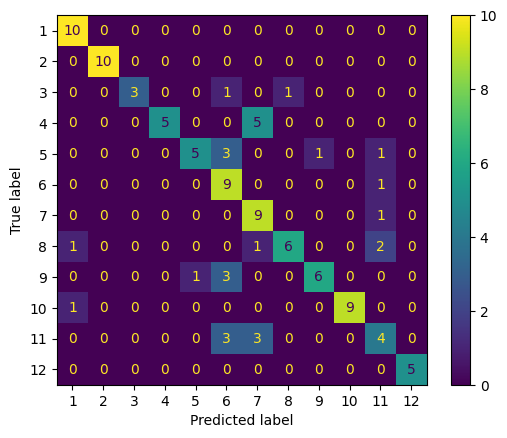

In [ ]:
history_0 = []
model_0 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation = 'relu', input_shape = (70, 70, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(22, activation=tf.nn.softmax)
])
model_0.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
history_0 = model_0.fit(train_images, train_labels, batch_size=64, epochs=20, validation_data = (val_images, val_labels))

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
y_pred_0 = model_0.predict(test_images)
y_pred_0 = np.argmax(y_pred_0, axis=1)

conf_mat = ConfusionMatrixDisplay.from_predictions(test_labels, y_pred_0)
report = classification_report(test_labels, y_pred_0)
print(report)
scores_0 = model_0.evaluate(test_images,test_labels)

history_dict_0 = history_0.history
loss_values = history_dict_0['loss']
val_loss_values = history_dict_0['val_loss']

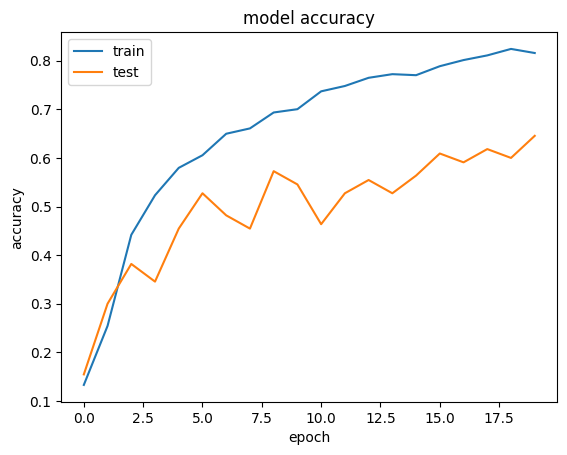

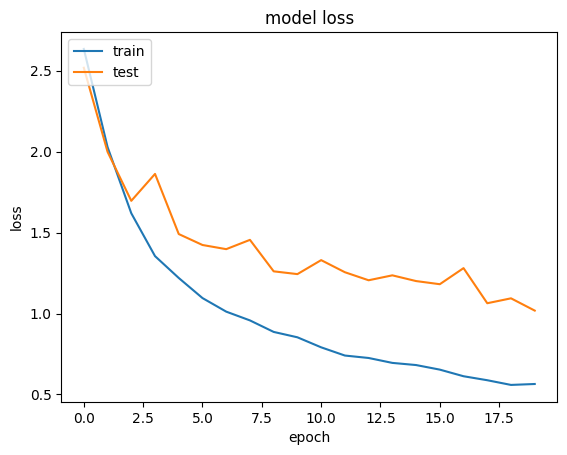

In [ ]:
# summarize history for accuracy
plt.plot(history_0.history['accuracy'])
plt.plot(history_0.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_0.history['loss'])
plt.plot(history_0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **MODEL 1**

In [ ]:
model = []
history = []

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (70, 70, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(22, activation=tf.nn.softmax)
])

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, batch_size=64, epochs=20, validation_data = (val_images, val_labels))

Epoch 1/20
67/67 [==============================] - 3s 13ms/step - loss: 2.2606 - accuracy: 0.2824 - val_loss: 2.2036 - val_accuracy: 0.3091
Epoch 2/20
67/67 [==============================] - 1s 9ms/step - loss: 1.6471 - accuracy: 0.4822 - val_loss: 1.9025 - val_accuracy: 0.3818
Epoch 3/20
67/67 [==============================] - 1s 8ms/step - loss: 1.2810 - accuracy: 0.5796 - val_loss: 1.6191 - val_accuracy: 0.4455
Epoch 4/20
67/67 [==============================] - 1s 8ms/step - loss: 1.0740 - accuracy: 0.6500 - val_loss: 1.4941 - val_accuracy: 0.5091
Epoch 5/20
67/67 [==============================] - 1s 8ms/step - loss: 0.9207 - accuracy: 0.7007 - val_loss: 1.4231 - val_accuracy: 0.5182
Epoch 6/20
67/67 [==============================] - 1s 8ms/step - loss: 0.8428 - accuracy: 0.7260 - val_loss: 1.3730 - val_accuracy: 0.5273
Epoch 7/20
67/67 [==============================] - 1s 8ms/step - loss: 0.7572 - accuracy: 0.7628 - val_loss: 1.3302 - val_accuracy: 0.6273
Epoch 8/20
67/67 [=

4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           1       0.67      1.00      0.80        10
           2       0.83      1.00      0.91        10
           3       1.00      0.80      0.89         5
           4       0.75      0.60      0.67        10
           5       0.83      0.50      0.62        10
           6       0.77      1.00      0.87        10
           7       0.88      0.70      0.78        10
           8       0.90      0.90      0.90        10
           9       0.91      1.00      0.95        10
          10       1.00      0.80      0.89        10
          11       0.70      0.70      0.70        10
          12       1.00      1.00      1.00         5

    accuracy                           0.83       110
   macro avg       0.85      0.83      0.83       110
weighted avg       0.84      0.83      0.82       110



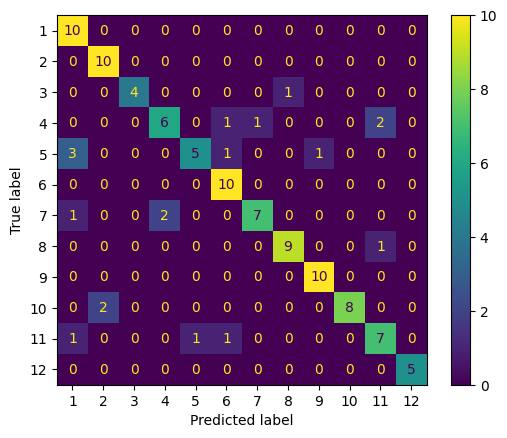

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)

conf_mat = ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)
report = classification_report(test_labels, y_pred)
print(report)

4/4 [==============================] - 0s 5ms/step - loss: 0.5493 - accuracy: 0.8273


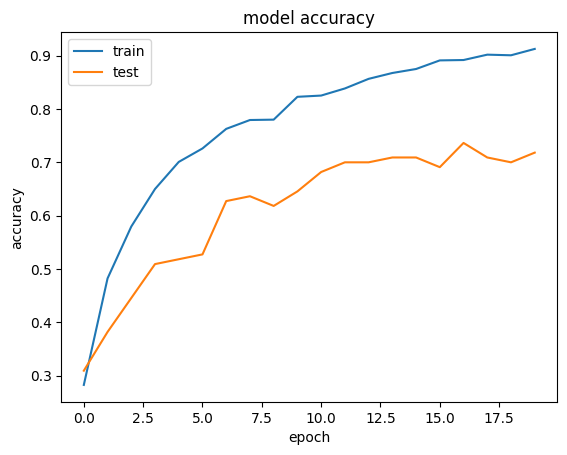

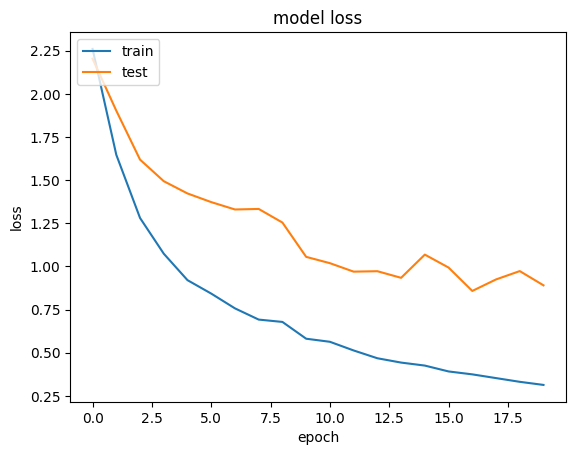

In [ ]:
scores = model.evaluate(test_images,test_labels)

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **MODEL 2**

In [ ]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (70, 70, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(22, activation=tf.nn.softmax)
])

In [ ]:
model_2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_2 = model_2.fit(train_images, train_labels, batch_size=128, epochs=50, validation_data = (val_images, val_labels))

Epoch 1/50
34/34 [==============================] - 6s 48ms/step - loss: 2.5463 - accuracy: 0.1320 - val_loss: 2.5730 - val_accuracy: 0.1182
Epoch 2/50
34/34 [==============================] - 1s 29ms/step - loss: 2.2637 - accuracy: 0.2061 - val_loss: 2.1009 - val_accuracy: 0.2364
Epoch 3/50
34/34 [==============================] - 1s 29ms/step - loss: 1.7501 - accuracy: 0.3868 - val_loss: 1.7857 - val_accuracy: 0.3091
Epoch 4/50
34/34 [==============================] - 1s 29ms/step - loss: 1.3478 - accuracy: 0.5302 - val_loss: 1.4536 - val_accuracy: 0.4727
Epoch 5/50
34/34 [==============================] - 1s 29ms/step - loss: 1.1629 - accuracy: 0.6029 - val_loss: 1.3461 - val_accuracy: 0.4636
Epoch 6/50
34/34 [==============================] - 1s 28ms/step - loss: 0.9975 - accuracy: 0.6603 - val_loss: 1.3254 - val_accuracy: 0.5364
Epoch 7/50
34/34 [==============================] - 1s 29ms/step - loss: 0.8664 - accuracy: 0.7073 - val_loss: 1.1864 - val_accuracy: 0.5727
Epoch 8/50
34

4/4 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         5
           4       0.90      0.90      0.90        10
           5       1.00      0.80      0.89        10
           6       0.62      1.00      0.77        10
           7       1.00      0.90      0.95        10
           8       1.00      0.90      0.95        10
           9       0.91      1.00      0.95        10
          10       1.00      1.00      1.00        10
          11       0.83      0.50      0.62        10
          12       0.83      1.00      0.91         5

    accuracy                           0.91       110
   macro avg       0.93      0.92      0.91       110
weighted avg       0.93      0.91      0.91       110



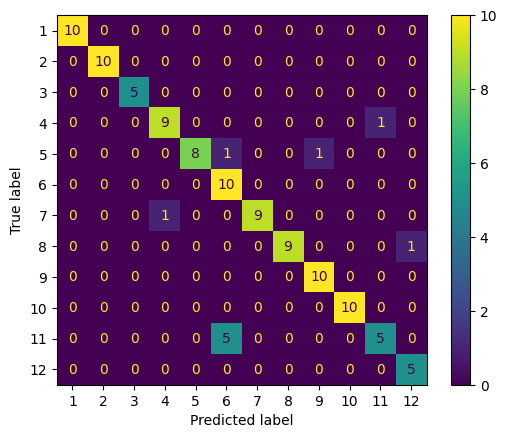

In [ ]:
y_pred_2 = model_2.predict(test_images)
y_pred_2 = np.argmax(y_pred_2, axis=1)

conf_mat = ConfusionMatrixDisplay.from_predictions(test_labels, y_pred_2)
report = classification_report(test_labels, y_pred_2)
print(report)

4/4 [==============================] - 0s 6ms/step - loss: 0.3880 - accuracy: 0.9091


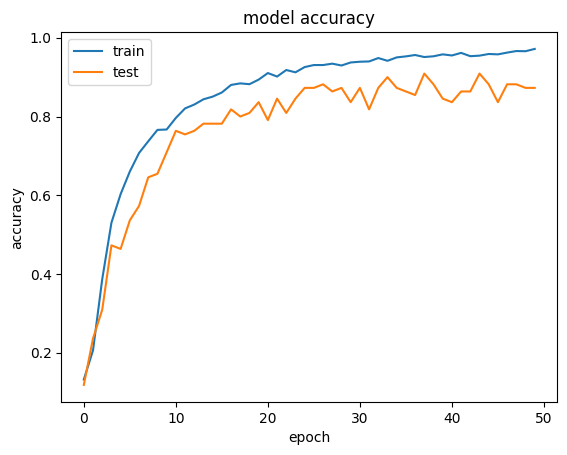

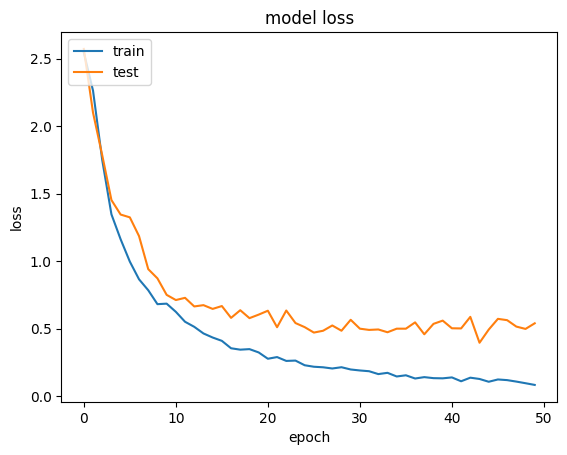

In [ ]:
scores = model_2.evaluate(test_images,test_labels)

history_dict_2 = history_2.history
loss_values = history_dict_2['loss']
val_loss_values = history_dict_2['val_loss']

# summarize history for accuracy
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **MODEL 3**

In [ ]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (70, 70, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(22, activation=tf.nn.softmax)
])

In [ ]:
model_3.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_3 = model_3.fit(train_images, train_labels, batch_size=128, epochs=50, validation_data = (val_images, val_labels))

Epoch 1/50
34/34 [==============================] - 6s 41ms/step - loss: 1.6740 - accuracy: 0.5206 - val_loss: 3.3908 - val_accuracy: 0.0909
Epoch 2/50
34/34 [==============================] - 1s 32ms/step - loss: 0.8422 - accuracy: 0.7340 - val_loss: 5.7070 - val_accuracy: 0.0909
Epoch 3/50
34/34 [==============================] - 1s 31ms/step - loss: 0.5970 - accuracy: 0.8117 - val_loss: 7.0937 - val_accuracy: 0.0909
Epoch 4/50
34/34 [==============================] - 1s 32ms/step - loss: 0.4849 - accuracy: 0.8470 - val_loss: 7.8930 - val_accuracy: 0.0909
Epoch 5/50
34/34 [==============================] - 1s 33ms/step - loss: 0.3728 - accuracy: 0.8809 - val_loss: 10.6068 - val_accuracy: 0.0909
Epoch 6/50
34/34 [==============================] - 1s 35ms/step - loss: 0.3211 - accuracy: 0.8949 - val_loss: 13.4976 - val_accuracy: 0.0909
Epoch 7/50
34/34 [==============================] - 1s 35ms/step - loss: 0.3237 - accuracy: 0.8985 - val_loss: 11.3546 - val_accuracy: 0.0909
Epoch 8/50

4/4 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           1       0.91      1.00      0.95        10
           2       0.83      1.00      0.91        10
           3       1.00      0.60      0.75         5
           4       1.00      0.90      0.95        10
           5       0.59      1.00      0.74        10
           6       0.77      1.00      0.87        10
           7       1.00      0.80      0.89        10
           8       1.00      0.40      0.57        10
           9       0.91      1.00      0.95        10
          10       1.00      0.90      0.95        10
          11       1.00      0.50      0.67        10
          12       0.62      1.00      0.77         5

    accuracy                           0.85       110
   macro avg       0.89      0.84      0.83       110
weighted avg       0.89      0.85      0.84       110



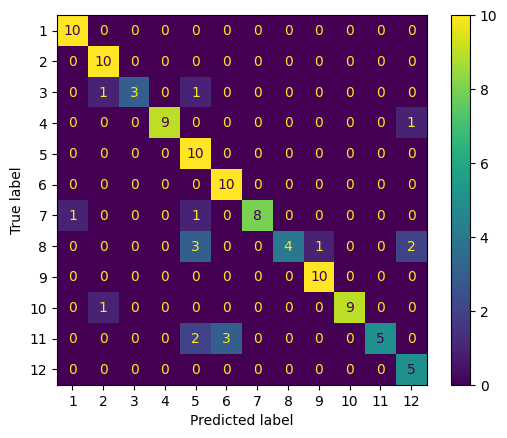

In [ ]:
y_pred_3 = model_3.predict(test_images)
y_pred_3 = np.argmax(y_pred_3, axis=1)

conf_mat = ConfusionMatrixDisplay.from_predictions(test_labels, y_pred_3)
report = classification_report(test_labels, y_pred_3)
print(report)

4/4 [==============================] - 0s 7ms/step - loss: 1.0994 - accuracy: 0.8455


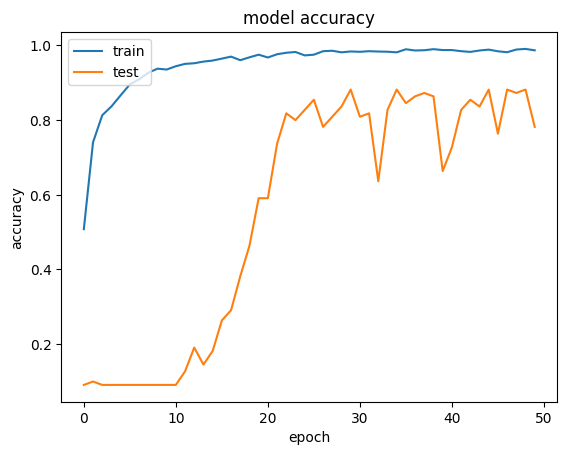

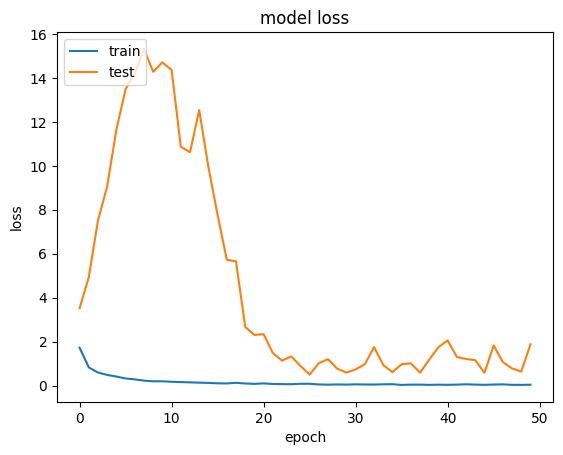

In [ ]:
scores = model_3.evaluate(test_images,test_labels)

history_dict_3 = history_3.history
loss_values = history_dict_3['loss']
val_loss_values = history_dict_3['val_loss']

# summarize history for accuracy
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation = 'relu', input_shape = (70, 70, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (5, 5 ), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (5, 5), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(22, activation=tf.nn.softmax)
])

model_4.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
history_4 = []
history_4 = model_4.fit(train_images, train_labels, batch_size=128, epochs=50, validation_data = (val_images, val_labels))

Epoch 1/50
34/34 [==============================] - 9s 163ms/step - loss: 2.5508 - accuracy: 0.1306 - val_loss: 2.5870 - val_accuracy: 0.2091
Epoch 2/50
34/34 [==============================] - 1s 37ms/step - loss: 2.1450 - accuracy: 0.2583 - val_loss: 1.8398 - val_accuracy: 0.3727
Epoch 3/50
34/34 [==============================] - 4s 116ms/step - loss: 1.5406 - accuracy: 0.4649 - val_loss: 1.4399 - val_accuracy: 0.5000
Epoch 4/50
34/34 [==============================] - 2s 65ms/step - loss: 1.2551 - accuracy: 0.5648 - val_loss: 1.2020 - val_accuracy: 0.5545
Epoch 5/50
34/34 [==============================] - 3s 85ms/step - loss: 1.0934 - accuracy: 0.6275 - val_loss: 1.0602 - val_accuracy: 0.6091
Epoch 6/50
34/34 [==============================] - 3s 76ms/step - loss: 0.9620 - accuracy: 0.6795 - val_loss: 0.9311 - val_accuracy: 0.6727
Epoch 7/50
34/34 [==============================] - 2s 52ms/step - loss: 0.8617 - accuracy: 0.7155 - val_loss: 1.0250 - val_accuracy: 0.7000
Epoch 8/50


4/4 [==============================] - 0s 98ms/step


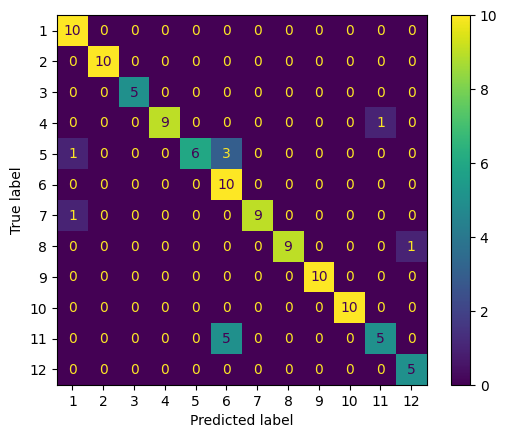

In [ ]:
y_pred_4 = model_4.predict(test_images)
y_pred_4 = np.argmax(y_pred_4, axis=1)

conf_mat = ConfusionMatrixDisplay.from_predictions(test_labels, y_pred_4)

4/4 [==============================] - 1s 271ms/step - loss: 0.5162 - accuracy: 0.8909


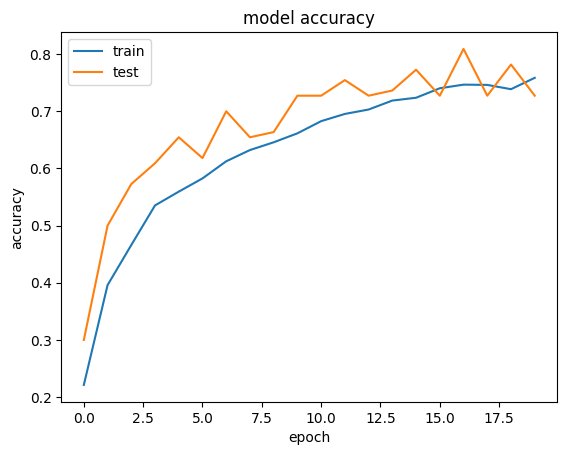

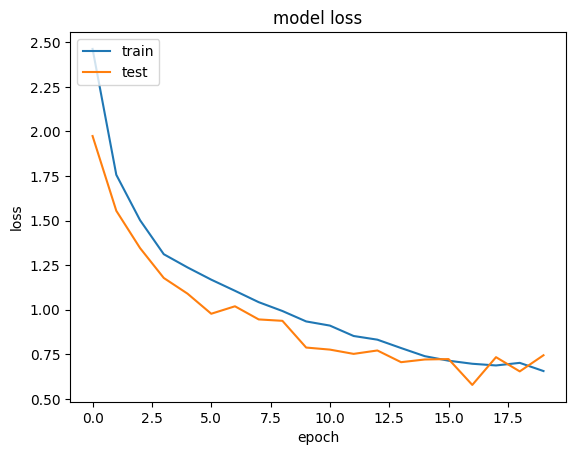

In [ ]:
scores = model_4.evaluate(test_images,test_labels)

history_dict_4 = history_4.history
loss_values = history_dict_4['loss']
val_loss_values = history_dict_4['val_loss']

# summarize history for accuracy
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Rescale
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)



# data transfer from directories to batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                               batch_size= 64,
                                               target_size= (70,70),
                                               class_mode = "categorical")

test_data = test_datagen.flow_from_directory(directory = test_dir,
                                               batch_size = 64,
                                               target_size = (70,70),
                                               class_mode = "categorical")

val_data = valid_datagen.flow_from_directory(directory = val_dir,
                                               batch_size = 64,
                                               target_size = (70,70),
                                               class_mode = "categorical")

Found 4274 images belonging to 22 classes.
Found 110 images belonging to 22 classes.
Found 110 images belonging to 22 classes.
